In [8]:
import os
import numpy as np
import torch
import h5py
from f_model import LSTM_ManyToOne
from f_utils import calc_accuracy,eval_help,eval_variable_help
from f_dataloader import Data_Query
import parameters as par
import faiss
import tqdm


In [3]:
with open(os.path.join(par.ROOT_DIR, "splits/Shopping100k/imgs_test.txt")) as f:
            img_data = f.read().splitlines()

In [9]:

gallery_feat=np.load(par.FEAT_TEST_SENZA_N)
test_labels = np.loadtxt(os.path.join(par.ROOT_DIR,par.LABEL_TEST), dtype=int)
path=par.DATA_TEST
Data_test = h5py.File(path)
t_id=Data_test['t']#id del target 
query_labels=test_labels[t_id]
test_data=Data_Query(Data_test=Data_test,gallery_feat=gallery_feat,label_data=test_labels,N=par.N)
gallery_loader=torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False,
                                        sampler=torch.utils.data.SequentialSampler(test_data),
                                            drop_last=False)

model=LSTM_ManyToOne(input_size=151,seq_len=par.N,output_size=4080,hidden_dim=4080,n_layers=par.NUM_LAYER,drop_prob=0.5)
last_train=par.MODEL_EVAL
path_pretrained_model=os.path.join(par.LOG_DIR,"{last_train}/best_model.pkl".format(last_train=last_train))
#load_pretrained_model
model.load_state_dict(torch.load(path_pretrained_model))
model.cuda()
if (par.Eval_variable_legnth):
    predicted_tfeat=eval_variable_help(model,gallery_loader)
else:
    predicted_tfeat= eval_help(model,gallery_loader)

log_dir=os.path.join(par.LOG_DIR,"log_eval.txt")
#evaluate the top@k results
dim = 4080  # dimension
database = gallery_feat
queries = predicted_tfeat# Dipende dallo step di tempo


Dataset is loaded. Size:  14361
Model is loaded...


100%|██████████| 449/449 [00:23<00:00, 19.43it/s]


In [12]:
num_query

14361

In [15]:
k = 5
print("N is :",par.N)
num_database = database.shape[0]
num_query = queries.shape[0]
print("Step:{s} ,Num of image in database is {n1}, Num of query img is {n2}".format(s=par.N,n1=num_database,n2=num_query))

index = faiss.IndexFlatL2(dim)
index.add(database)
_, knn = index.search(queries, k)
assert (query_labels.shape[0] == queries.shape[0])
num_foto=0
hits = 0


N is : 8
Step:8 ,Num of image in database is 20000, Num of query img is 14361
2901 Female/4_Shirts_blouses/0045884_16.jpg Female/4_Shirts_blouses/0065625_12.jpg
13810 Female/10_Swimming/0050159_10.jpg Female/6_Jumpers/0036484_10.jpg
4251 Female/4_Shirts_blouses/0018334_12.jpg Male/7_Shorts/0017456_19.jpg
12407 Female/4_Shirts_blouses/0033057_14.jpg Female/9_Jeans/0014330_12.jpg
955 Female/15_Skirts/0054842_10.jpg Female/9_Jeans/0012467_14.jpg
5581 Female/4_Shirts_blouses/0066764_12.jpg Male/5_T_shirts/0020672_10.jpg
11329 Female/5_T_shirts_tops/0019041_12.jpg Male/5_T_shirts/0004431_14.jpg
1933 Female/5_T_shirts_tops/0059787_10.jpg Male/5_T_shirts/0027416_10.jpg
1197 Female/7_Shorts/0005291_2.jpg Male/5_T_shirts/0035911_12.jpg
17253 Male/5_T_shirts/0027472_14.jpg Male/5_T_shirts/0023835_1.jpg
16997 Female/6_Jumpers/0032740_2.jpg Female/10_Swimming/0043428_12.jpg


<Figure size 762x1100 with 0 Axes>

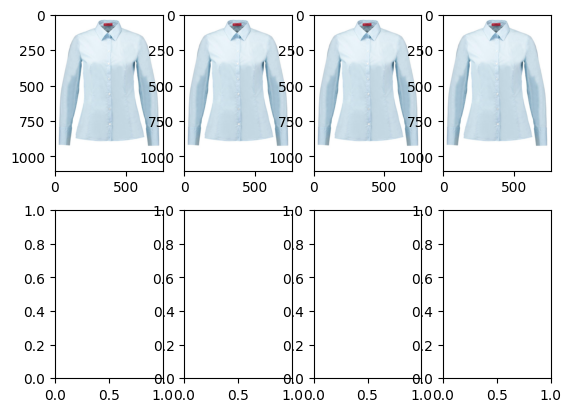

In [25]:
import matplotlib.pyplot as plt
im1=os.path.join(par.ROOT_DIR,"dati/Images/Female/4_Shirts_blouses/0045884_16.jpg")
# read images from computer

import matplotlib.ticker as plticker
try:
    from PIL import Image
except ImportError:
    import Image

# Open image file
image = Image.open(im1)
my_dpi=300.

# Set up figure
fig=plt.figure(figsize=(float(image.size[0])/my_dpi,float(image.size[1])/my_dpi),dpi=my_dpi)

f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(image)
axarr[0,1].imshow(image)
axarr[0,2].imshow(image)
axarr[0,3].imshow(image)
  

In [ ]:
tq=range(num_query)
for q in tq: # itera i dati predicted_tfeat
    neighbours_idxs = knn[q]# gli indici dei k-feat più simili alla predicted_tfeat[q]
    for n_idx in neighbours_idxs:
        if (test_labels[n_idx] == query_labels[q]).all():
            print(n_idx,img_data[q], img_data[n_idx])
            hits += 1
            break
    if(hits>10):
        break
    #tq.set_description("Num of hit {h}".format(h=hits))